# Analysis of `vehicle-summary.xml`

In [1]:
import pprint, math, datetime
from time import strftime, gmtime
from lxml import etree
import matplotlib.pyplot as plt
import numpy as np

from paths import normal, scenarios

plt.rcParams["figure.figsize"] = 30, 20
plt.rcParams["font.size"] = 20
plt.rcParams["axes.titlesize"] = 50
plt.rcParams["axes.titlepad"] = 80

def get_vehicle_step_summary(file_path):
    class SAXParser:
        def __init__(self):
            self.steps = []
            self.current_step = {}

        def start(self, tag, attr):
            if tag == "step":
                self.current_step["time"] = attr["time"]
                self.current_step["meanWaitingTime"] = float(attr["meanWaitingTime"])
                self.current_step["meanTravelTime"] = float(attr["meanTravelTime"])
                self.current_step["meanSpeed"] = float(attr["meanSpeed"])
                self.current_step["meanSpeedRelative"] = float(attr["meanSpeedRelative"])

        def end(self, tag):
            if tag == "step":
                self.steps.append(self.current_step)
                self.current_step = {}

        def close(self):
            pass

    sax_parser = SAXParser()
    xml_parser = etree.XMLParser(target=sax_parser)
    etree.parse(file_path, parser=xml_parser)

    return sax_parser.steps

def aggregate_by(values, interval=60):
    interval_steps = []
    interval_values = []

    interval_sum = 0
    for t in range(len(values)):
        interval_sum += values[t]

        if t > 0 and t % interval == 0:
            interval_steps.append(t - interval)
            interval_values.append(interval_sum / interval)
            interval_sum = 0

        # if t == len(values) - 1 and interval_sum > 0:
        #     interval_steps.append(math.ceil(t / interval))
        #     interval_values.append(interval_sum / interval)
        #     interval_sum = 0

    return (interval_steps, interval_values)

n_steps = get_vehicle_step_summary(f"{normal}/vehicle-summary.xml")

scenario_data = {}

for s in scenarios:
    steps = get_vehicle_step_summary(f"{s}/vehicle-summary.xml")
    scenario_data[s] = steps

### Compare mean travelTime/speed over time

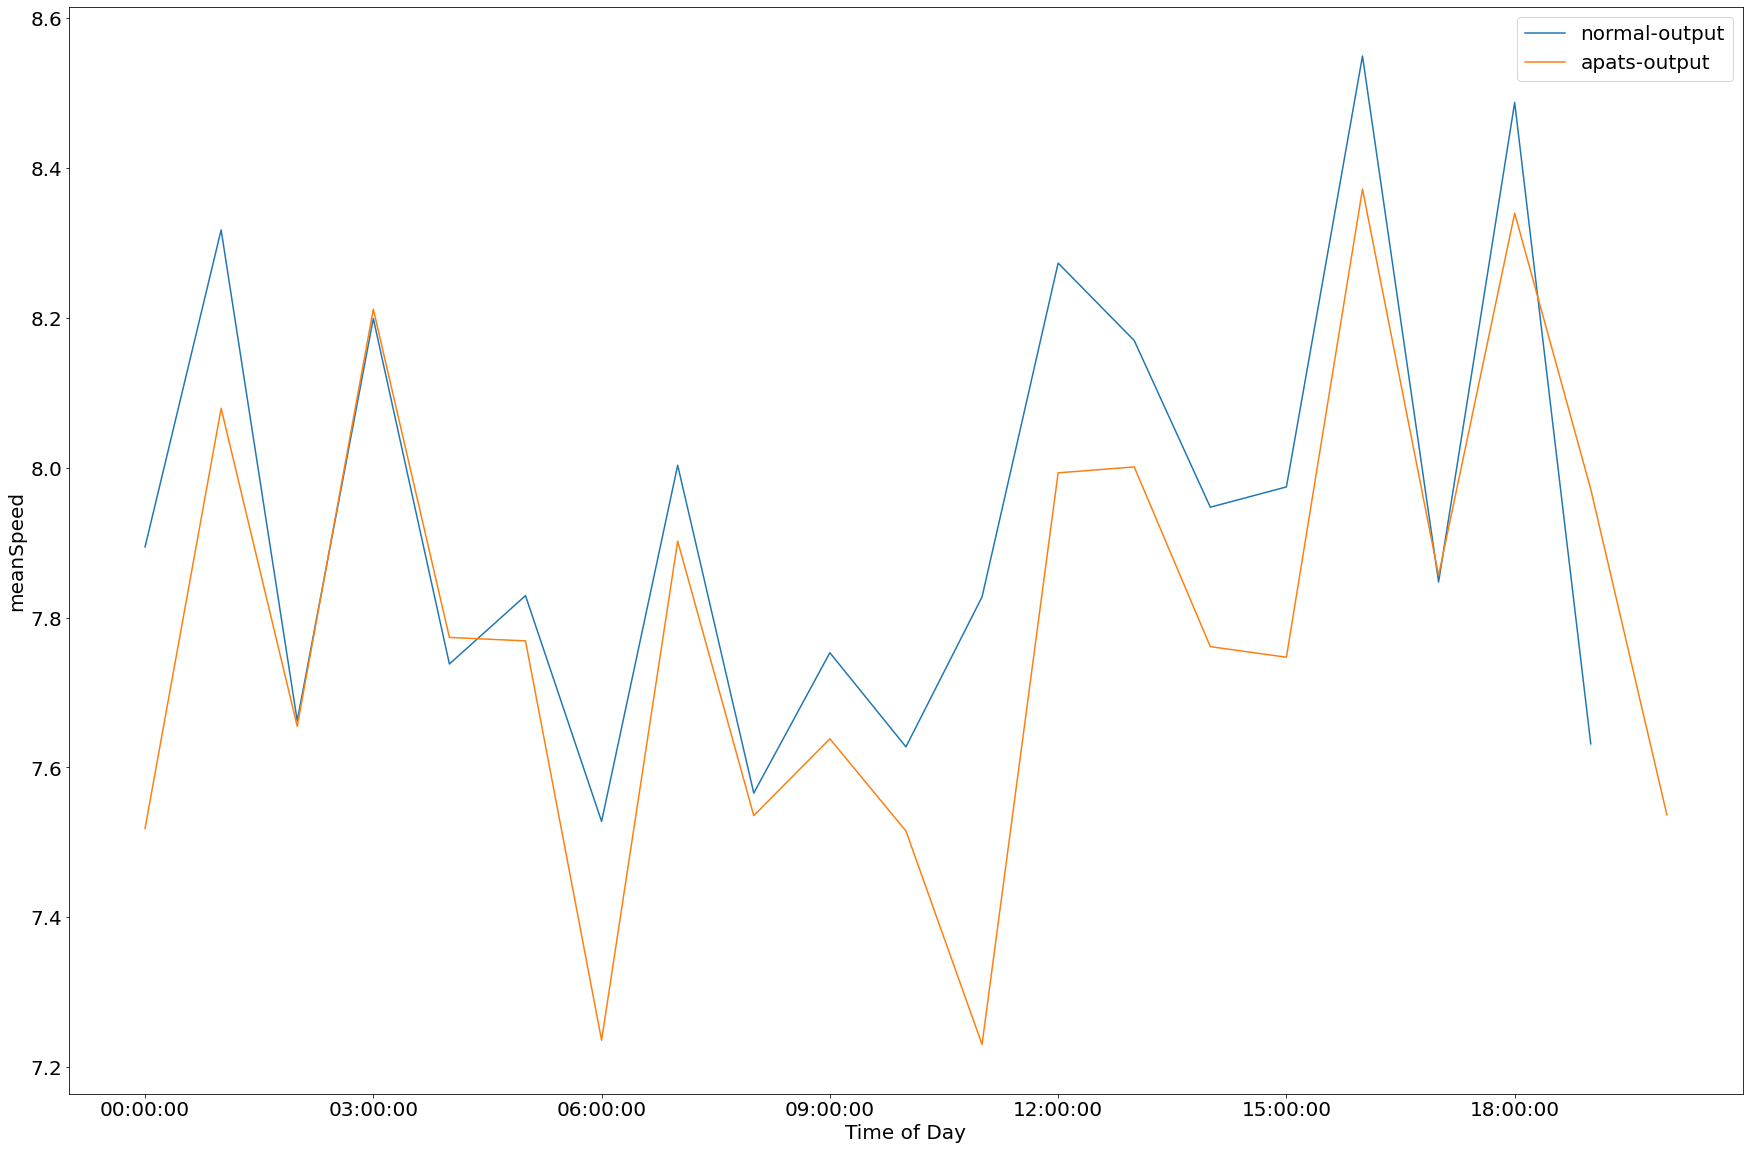

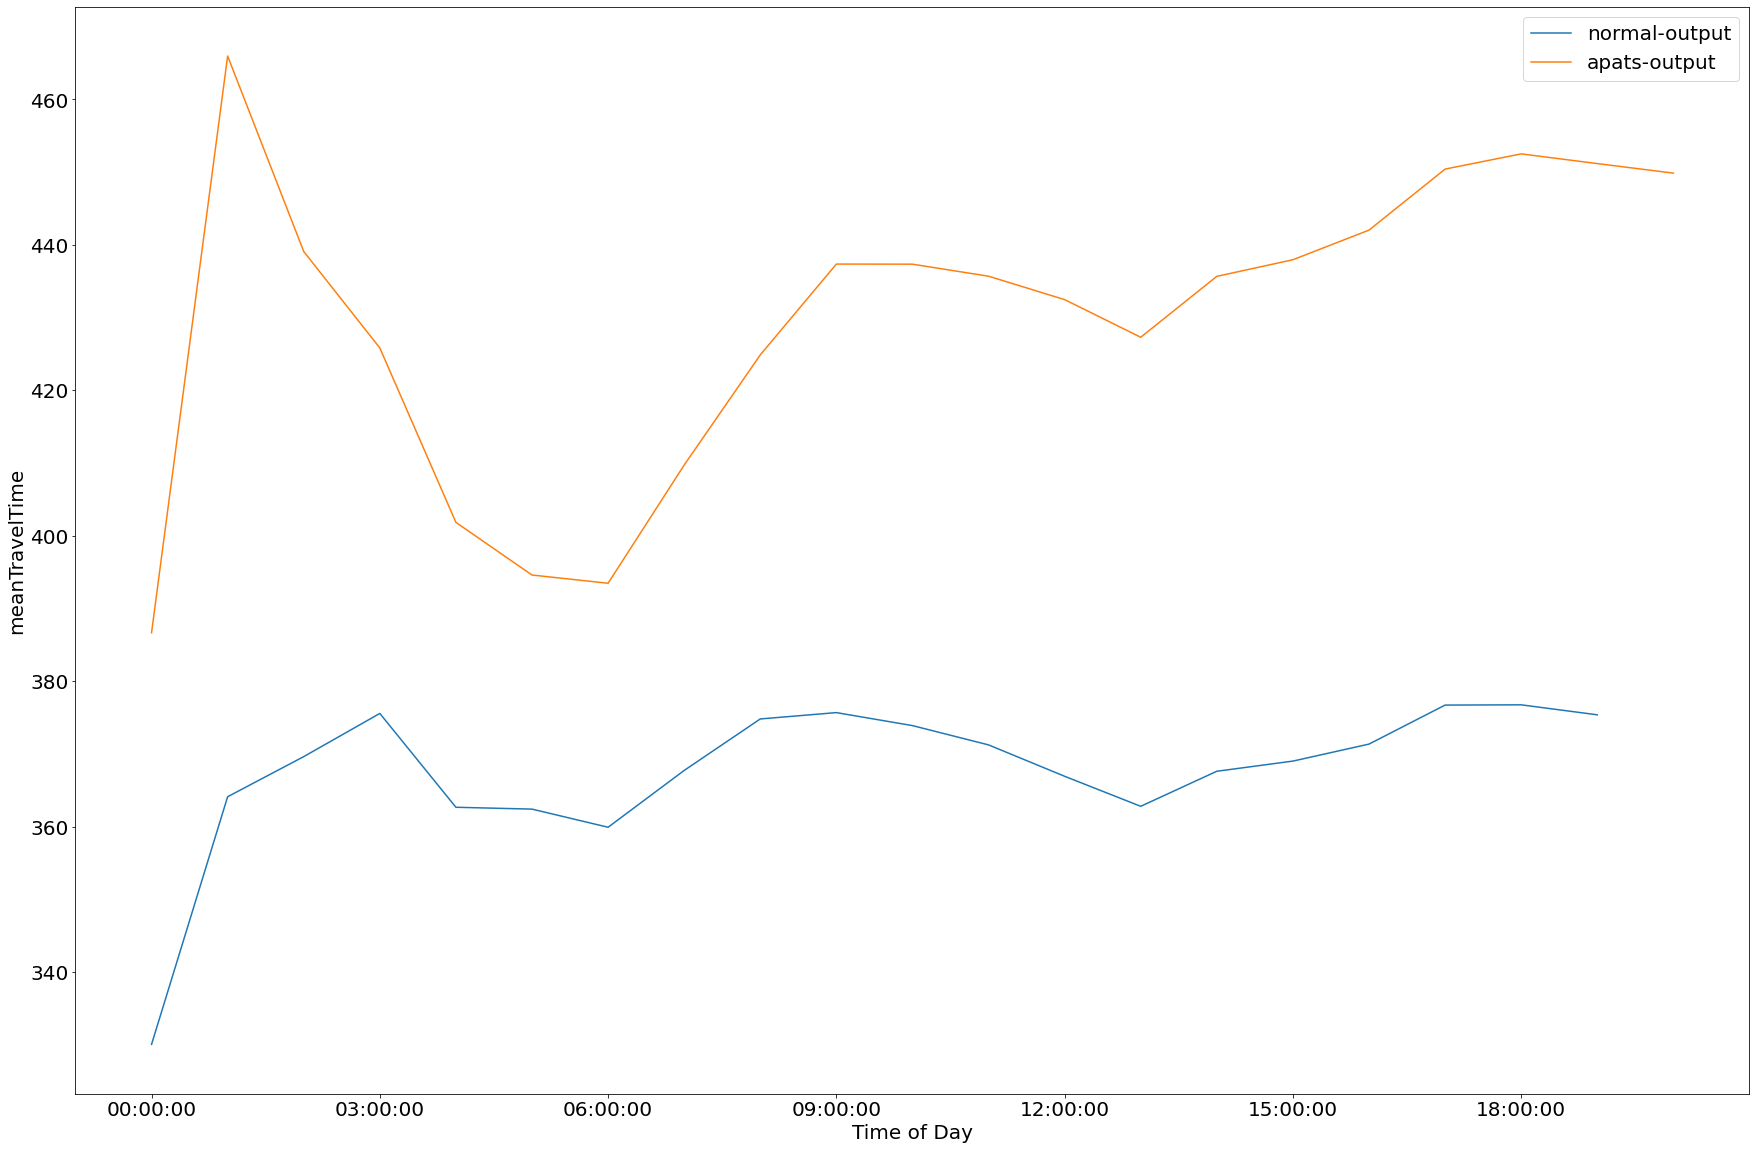

In [3]:
def plot_attribute(attr, interval=60*60):
    fig, ax = plt.subplots()

    mean_speeds = list(map(lambda s: s[attr], n_steps))

    x, y = aggregate_by(mean_speeds, interval=interval)
    ax.plot(x, y, label=normal)

    for s in scenarios:
        steps = scenario_data[s]
        mean_speeds = list(map(lambda s: s[attr], steps))
        x, y = aggregate_by(mean_speeds, interval=interval)
        ax.plot(x, y, label=s)

    ax.set_xlabel("Time of Day")
    xticks = x[0::3]
    xticks_labels = list(map(lambda t: strftime("%H:%M:%S", gmtime(t)), xticks))
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks_labels)

    ax.set_ylabel(attr)
    ax.legend(loc="upper right")

interval = 60*60
plot_attribute("meanSpeed", interval=interval)
plot_attribute("meanTravelTime", interval=interval)